# Room Occupancy Estimation using Machine Learning

## Introduction

This notebook aims to analyze and develop machine learning models for **Room Occupancy Estimation** using non-intrusive environmental sensors such as **temperature, light, sound, CO2, and PIR (Passive Infrared)**. The goal is to predict the number of occupants in a room based on sensor data.

This project is developed as part of the **Machine Learning Challenge (Aprendizagem Computacional), 2025** at **DEI, FCT, University of Coimbra**. The objective of the challenge is to identify a real-world classification problem, apply simple machine learning models, and evaluate their effectiveness.

## Dataset Information

The dataset used in this project is [**Room Occupancy Estimation**](https://archive.ics.uci.edu/dataset/864/room+occupancy+estimation), which consists of **10129 instances and 18 features**. The data was collected over four days in a controlled environment, where occupancy varied between **0 and 3 people**.

- **Sensor Types Used:**
  - **Temperature**
  - **Light**
  - **Sound**
  - **CO2**
  - **Passive Infrared (PIR)**

- **Experimental Setup:**
  - Data was collected in a **6m x 4.6m room**.
  - **7 sensor nodes** were deployed, transmitting data every **30 seconds**.
  - The PIR, CO2, and sound sensors required manual calibration.
  - The ground truth was manually recorded.

## Challenge Goals

The primary goals of this challenge are:
1. **Problem Identification:** Understand how environmental sensor data can be used for room occupancy estimation.
2. **Data Analysis:** Explore the dataset, clean, and preprocess it.
3. **Model Construction:** Implement at least **two simple machine learning models** (e.g., Decision Trees, K-Nearest Neighbors, Logistic Regression).
4. **Evaluation Metrics:** Assess model performance using appropriate evaluation metrics.
5. **Documentation & Submission:** Record findings, methodologies, and challenges faced.

## Next Steps

1. Load and preprocess the dataset.
2. Perform exploratory data analysis (EDA).
3. Train and evaluate machine learning models.
4. Compare model performance using visualization tools.

---

# Dataset Column Descriptions
| **Feature/Target**    | **Type**       | **Description**                                              | **Units**      |
|-------------------------|---------------|--------------------------------------------------------------|---------------|
| `Date`                 | Date          | Date when the data was recorded                              | YYYY/MM/DD    |
| `Time`                 | Time          | Time when the data was recorded                              | HH:MM:SS      |
| `S1_Temp` – `S4_Temp`  | Continuous    | Ambient temperature measured at different sensor locations   | °C            |
| `S1_Light` – `S4_Light`| Integer       | Light intensity measured at different sensor locations       | Lux           |
| `S1_Sound` – `S4_Sound`| Continuous    | Sound levels measured using an amplifier output read by ADC  | Volts         |
| `S5_CO2`              | Integer       | Carbon dioxide (CO2) concentration in the room              | PPM           |
| `S5_CO2_Slope`       | Continuous    | Rate of change (slope) of CO2 concentration over time       | -             |
| `S6_PIR`, `S7_PIR`    | Binary/Integer | Motion detection using Passive Infrared (PIR) sensors       | - (0 = No motion, 1 = Motion detected) |
| `Room_Occupancy_Count` | Integer        | Ground truth number of occupants in the room                | -             |


**NOTE:** There are no missing (null) values in the dataset.

Install Required Libs: pip install scikit-learn pandas numpy scipy matplotlib seaborn

For report:
- DETERMINE PROBLEM, SOLUTION, OBJECTIVE;
- BREAKDOWN OF THE DATASET, DESCRIPTION OF VARIABLES AND TARGETS, NUMBER OF NULL VALUES 

In [ ]:
import pandas as pd
from ucimlrepo import fetch_ucirepo

#Converts hours, minutes, seconds to seconds for easier handling

def hms_to_seconds(t):
    h, m, s = [int(i) for i in str(t).split(':')]
    return 3600*h + 60*m + s
  
# fetch dataset 
room_occupancy_estimation = fetch_ucirepo(id=864) 
  
# data (as pandas dataframes) 
X = room_occupancy_estimation.data.features
y = room_occupancy_estimation.data.targets

# Get number of target elements of the same category
target_distribution = y.pivot_table(index=["Room_Occupancy_Count"], aggfunc="size")
print(target_distribution)

In [ ]:
# Example of data entries
X.join(y).head()

In [ ]:
X.describe()

,S6_PIR,S7_PIR
count,10129.000000,10129.000000
mean,0.090137,0.079574
std,0.286392,0.270645
min,0.000000,0.000000
25%,0.000000,0.000000
50%,0.000000,0.000000
75%,0.000000,0.000000
max,1.000000,1.000000


In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

# Set a theme for Seaborn plots
sns.set_theme()

# Histogram of "Room_Occupancy_Count"
plt.figure(figsize=(10, 6))
sns.barplot(x=["0", "1", "2", "3"], y=target_distribution.values)
plt.title("Room Occupancy Distribution")
plt.xlabel("Number of Occupants")
plt.ylabel("Occurences")
plt.show()

# We can see the dataset is unbalanced. Ruh-roh!

## EDA - Exploration Data Analysis

1. Remove rows with missing data - since there are no null values in the dataset, this step can be skipped.
2. Remove duplicate rows. Notice how the duplicate data is (mostly) constrained to late night / early mornings when the room is empty.

In [ ]:
# Create a list of strictly numeric feature names
numeric_features = X.select_dtypes(include="number").columns.tolist()

# Count and remove duplicates
mask_duplicates = X.duplicated(subset=numeric_features, keep="first")
count_duplicates = mask_duplicates.sum()

print(count_duplicates)

X1 = X.drop_duplicates(subset=numeric_features).select_dtypes(include="number")
y1 = y[~mask_duplicates]

In [ ]:
# Updated "Room_Occupancy_Count" after removing duplicates
target_distribution = y1.pivot_table(index=["Room_Occupancy_Count"], aggfunc="size")

print(target_distribution)

plt.figure(figsize=(10, 6))
sns.barplot(x=["0", "1", "2", "3"], y=target_distribution.values)
plt.title("Room Occupancy Distribution")
plt.xlabel("Number of Occupants")
plt.ylabel("Occurences")
plt.show()

In [ ]:
X["DateTime"] = pd.to_datetime(X["Date"] + " " + X["Time"])
X["Hour"] = X["DateTime"].dt.hour

# Plot occupancy by hour
plt.figure(figsize=(12,6))
sns.boxplot(x=X["Hour"], y=y["Room_Occupancy_Count"], palette="coolwarm")
plt.title("Occupancy Count by Hour of the Day")
plt.xlabel("Hour of the Day")
plt.ylabel("Occupancy Count")
plt.show()

## Grouped Univariate Visualization

In [ ]:
# Grouping sensor variables
sensor_groups = {
    "Temperature (°C)": ["S1_Temp", "S2_Temp", "S3_Temp", "S4_Temp"],
    "Light (Lux)": ["S1_Light", "S2_Light", "S3_Light", "S4_Light"],
    "Sound (Volts)": ["S1_Sound", "S2_Sound", "S3_Sound", "S4_Sound"],
    "CO2 (PPM)": ["S5_CO2", "S5_CO2_Slope"],
}

# Plot continuous variables with KDE plots
fig, axes = plt.subplots(len(sensor_groups) + 1, 1, figsize=(10, 18))  # Extra subplot for PIR
for ax, (group_name, features) in zip(axes[:-1], sensor_groups.items()):
    for feature in features:
        sns.kdeplot(X1[feature], ax=ax, label=feature, fill=True, alpha=0.4)
    
    ax.set_title(f"{group_name} Distribution")
    ax.legend()
    ax.set_xlabel("Value")
    ax.set_ylabel("Density")

# Separate plot for PIR Motion (binary data) using bar plots
ax_pir = axes[-1]
pir_data = X1[["S6_PIR", "S7_PIR"]].melt(var_name="Sensor", value_name="Value")
sns.countplot(x="Value", hue="Sensor", data=pir_data, ax=ax_pir)

ax_pir.set_title("PIR Motion Detection Counts")
ax_pir.set_xlabel("Motion Detected (0 = No, 1 = Yes)")
ax_pir.set_ylabel("Count")
ax_pir.legend(title="Sensor")

plt.tight_layout()
plt.show()


In [ ]:
X1y1 = X1.join(y1)

plt.figure(figsize=(10, 6))
sns.heatmap(X1y1.corr(), annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Feature Correlation Heatmap")
plt.show()

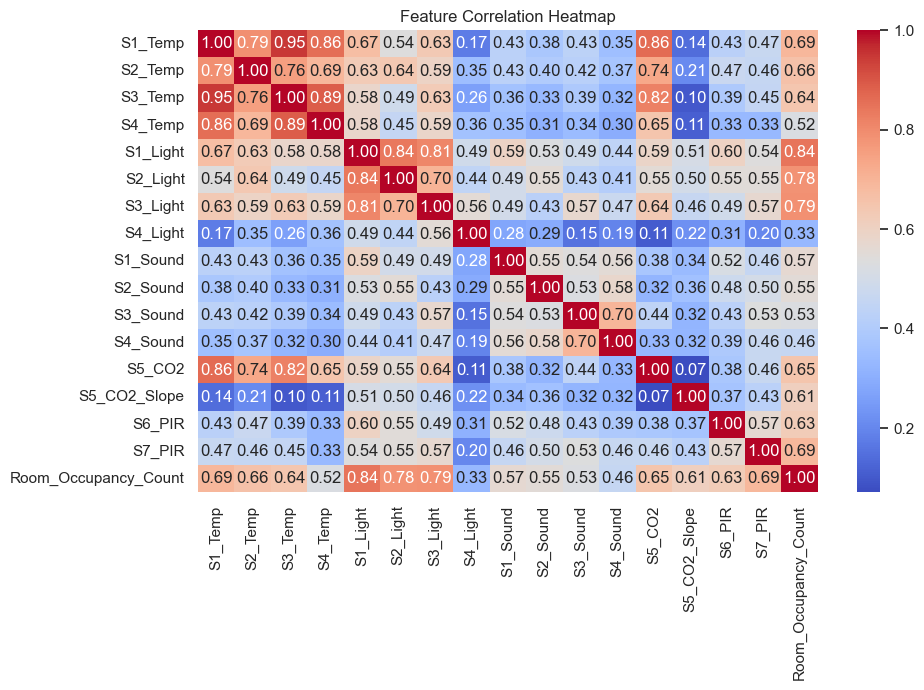

['S1_Temp',
 'S2_Temp',
 'S3_Temp',
 'S4_Temp',
 'S1_Light',
 'S2_Light',
 'S3_Light',
 'S4_Light',
 'S1_Sound',
 'S2_Sound',
 'S3_Sound',
 'S4_Sound',
 'S5_CO2',
 'S5_CO2_Slope',
 'S6_PIR',
 'S7_PIR',
 'Room_Occupancy_Count']

In [ ]:
corr_matrix = X1y1.corr()

plt.figure(figsize=(10, 6))
sns.heatmap(corr_matrix, annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Feature Correlation Heatmap")
plt.show()

We now study different sampling methods in order to determine the method that provides the most accuracy after training.

## Case studies:
- Baseline (no sampling method applied)
- Oversampling
    - RandomOverSampler
    - SMOTE
    - ADASYN
- Undersampling
    - RandomUnderSampler
    - NearMiss
    - CondensedNearestNeighbor

In [ ]:
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler

X2y2 = X1y1.copy()

# Standardize Temperature & Sound
std_scaler = StandardScaler()
std_features = ['S1_Temp', 'S2_Temp', 'S3_Temp', 'S4_Temp', 'S1_Sound', 'S2_Sound', 'S3_Sound', 'S4_Sound']
X2y2[std_features] = std_scaler.fit_transform(X1y1[std_features])

# Min-Max Scale Light sensors
minmax_scaler = MinMaxScaler()
minmax_features = ['S1_Light', 'S2_Light', 'S3_Light', 'S4_Light']
X2y2[minmax_features] = minmax_scaler.fit_transform(X1y1[minmax_features])

# Robust Scale CO2 & CO2 Slope
robust_scaler = RobustScaler()
robust_features = ['S5_CO2', 'S5_CO2_Slope']
X2y2[robust_features] = robust_scaler.fit_transform(X1y1[robust_features])

# No standardization necessary for PIR sensor data, since it is already constrained [0, 1]

X2y2

,S1_Temp,S2_Temp,S3_Temp,S4_Temp,S1_Light,S2_Light,S3_Light,S4_Light,S1_Sound,S2_Sound,S3_Sound,S4_Sound,S5_CO2,S5_CO2_Slope,S6_PIR,S7_PIR,Room_Occupancy_Count
0,-1.484283,-1.359085,-1.215903,-1.131861,0.733333,0.131783,0.189286,0.540541,-0.302849,0.209158,-0.255726,-0.363976,0.166667,6.451613,0,0,1
1,-1.484283,-1.359085,-1.215903,-0.964796,0.733333,0.127907,0.189286,0.540541,2.219398,-0.283932,-0.255726,-0.363976,0.166667,5.419355,0,0,1
2,-1.320182,-1.359085,-1.352076,-0.964796,0.733333,0.131783,0.189286,0.540541,0.735723,-0.072608,-0.210389,-0.363976,0.166667,4.354839,0,0,1
3,-1.320182,-1.359085,-1.215903,-0.964796,0.733333,0.131783,0.189286,0.540541,0.676376,-0.107828,-0.165052,-0.131126,0.166667,3.258065,0,0,1
4,-1.320182,-1.359085,-1.215903,-0.964796,0.733333,0.131783,0.192857,0.540541,-0.006114,-0.248711,-0.255726,-0.363976,0.166667,2.129032,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10124,-1.156082,-0.742247,-0.920862,-1.326769,0.036364,0.027132,0.117857,0.297297,-0.273176,-0.319153,-0.255726,-0.208743,-0.083333,0.000000,0,0,0
10125,-1.156082,-0.855875,-0.920862,-1.493834,0.036364,0.027132,0.121429,0.297297,-0.332523,-0.283932,-0.278394,-0.208743,-0.083333,0.000000,0,0,0
10126,-0.964631,-0.855875,-0.920862,-1.493834,0.036364,0.027132,0.121429,0.297297,-0.213829,-0.283932,-0.255726,-0.208743,-0.083333,0.000000,0,0,0
10127,-0.964631,-0.855875,-0.920862,-1.493834,0.036364,0.027132,0.121429,0.297297,-0.302849,-0.178270,-0.165052,-0.208743,-0.083333,0.000000,0,0,0


In [ ]:
from imblearn.over_sampling import RandomOverSampler, SMOTE, SMOTENC
from imblearn.under_sampling import RandomUnderSampler, NearMiss, CondensedNearestNeighbour

X2 = X2y2.drop(columns=["Room_Occupancy_Count"])
y2 = X2y2[["Room_Occupancy_Count"]]

sampler_tests = {}

# Baseline
sampler_tests["Baseline"] = [X2, y2]

# RandomOverSampler
sampler_tests["RandomOverSampler"] = [RandomOverSampler(sampling_strategy="auto", random_state=42).fit_resample(X2, y2)]

# SMOTE
sampler_tests["SMOTE"] = [SMOTE(sampling_strategy="auto", random_state=42).fit_resample(X2, y2)]

# SMOTENC - Categorical features [S6_PIR, S7_PIR]
sampler_tests["SMOTENC"] = [SMOTENC(sampling_strategy="auto", random_state=42, categorical_features=[14, 15]).fit_resample(X2, y2)]

# RandomUnderSampler
sampler_tests["RandomUnderSampler"] = [RandomUnderSampler(sampling_strategy="auto", random_state=42).fit_resample(X2, y2)]

# NearMiss
sampler_tests["NearMiss"] = [NearMiss(sampling_strategy="auto").fit_resample(X2, y2)]

# CondensedNearestNeighbour
sampler_tests["CondensedNearestNeighbour"] = [CondensedNearestNeighbour(sampling_strategy="auto", random_state=42).fit_resample(X2, y2)]

In [ ]:
# For each sampling method, perform tests with different correlation thresholds to determine which features can be disregarded

test_thresholds = [0.0, 0.2, 0.5, 0.8]

for test_method in sampler_tests:
    for threshold in test_thresholds:
        # Find features that have at least one correlation above the threshold (excluding the diagonal); abs() is used to find most and least correlated features.
        correlated_features = corr_matrix.abs().columns[(corr_matrix > threshold).sum() > 1]

        X3y3 = X2y2[correlated_features]

        print("Selected features:", correlated_features.tolist())

        X3y3.describe()

In [ ]:
# We also represent the data with a pairplot in order to better visualize the distribution of dataset samples, which can be useful to later establish a correlation threshold

# For representation purposes, we can reduce the number of datapoints by random sampling.
# X2y2_subsampled = X2y2.sample(frac=0.1, random_state=42)  # Take 10% of the data.

# plt.figure(figsize=(15, 15))
# sns.pairplot(X2y2, hue="Room_Occupancy_Count", diag_kind="hist", palette="coolwarm")
# plt.show()

## Manipulating data

- Removal of columns with lower correlation

In [ ]:
# Set a correlation threshold.
threshold = 0.6

# Find features that have at least one correlation above the threshold (excluding the diagonal); abs() is used to find most and least correlated features.
correlated_features = corr_matrix.abs().columns[(corr_matrix > threshold).sum() > 1]

X3y3 = X2y2[correlated_features]

print("Selected features:", correlated_features.tolist())

X3y3.describe()

We now normalize the data as is required for our model training method (KNN), even though this is unnecessary for methods like decision trees. **(ChatGPT was used to help select the best normalization technique based on the dataset summary)**:
- Temperature values (S1_Temp to S4_Temp):
    - Mean is around 25-26°C with a small standard deviation (~0.3 - 0.8).
    - The range is small (around 24.9 to 29.0).
    - Standardization (Z-score) would work well here.

- Light sensor values (S1_Light to S3_Light):
    - Huge variation (e.g., S2_Light ranges from 0 to 258).
    - Min-Max Scaling is a good option since it preserves relative differences and brings everything between 0 and 1.

- Sound sensor values (S3_Sound, S4_Sound):
    - Small values (0.04 - 3.67 V) but with a high standard deviation (~0.6).
    - Standardization (Z-score) is ideal here.

- CO2 (S5_CO2) and CO2 Slope (S5_CO2_Slope):
    - Large range in CO2 (345 - 1270 PPM) and very high standard deviation (~250).
    - CO2 slope has negative values and a large range (-6.29 to 8.98).
    - Robust Scaling is best to reduce the effect of outliers.

In [ ]:
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler

X4y4 = X3y3.copy()

# Standardize Temperature & Sound
std_scaler = StandardScaler()
X4y4[['S1_Temp', 'S2_Temp', 'S3_Temp', 'S4_Temp', 'S3_Sound', 'S4_Sound']] = std_scaler.fit_transform(
    X3y3[['S1_Temp', 'S2_Temp', 'S3_Temp', 'S4_Temp', 'S3_Sound', 'S4_Sound']]
)

# Min-Max Scale Light sensors
minmax_scaler = MinMaxScaler()
X4y4[['S1_Light', 'S2_Light', 'S3_Light']] = minmax_scaler.fit_transform(
    X3y3[['S1_Light', 'S2_Light', 'S3_Light']]
)

# Robust Scale CO2 & CO2 Slope
robust_scaler = RobustScaler()
X4y4[['S5_CO2', 'S5_CO2_Slope']] = robust_scaler.fit_transform(
    X3y3[['S5_CO2', 'S5_CO2_Slope']]
)

X4y4

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score

model_dtc = DecisionTreeClassifier()
model_knn = KNeighborsClassifier()

X_train, X_test, y_train, y_test = train_test_split(X1y1.drop(columns=['Room_Occupancy_Count']), X1y1['Room_Occupancy_Count'], test_size=0.3, random_state=123)

model_dtc.fit(X_train, y_train)
model_knn.fit(X_train, y_train)

# Predict & evaluate
y_pred_dtc = model_dtc.predict(X_train)
y_pred_knn = model_knn.predict(X_train)

#

accuracy_dtc = accuracy_score(y_train, y_pred_dtc)
accuracy_knn = accuracy_score(y_train, y_pred_knn)

print(f"Decision Tree Accuracy: {accuracy_dtc * 100:.2f}%")
print(f"K-Nearest Neighbors Accuracy: {accuracy_knn * 100:.2f}%")

y_pred_dtc = model_dtc.predict(X_test)
y_pred_knn = model_knn.predict(X_test)

accuracy_dtc = accuracy_score(y_test, y_pred_dtc)
accuracy_knn = accuracy_score(y_test, y_pred_knn)

In [ ]:
print(f"Decision Tree Accuracy: {accuracy_dtc * 100:.2f}%")
print(f"K-Nearest Neighbors Accuracy: {accuracy_knn * 100:.2f}%")